In [1]:
import pandas as pd

# Load data
trader_df = pd.read_csv('historical_data.csv')
sentiment_df = pd.read_csv('fear_greed_index.csv')

# Convert 'Timestamp IST' to datetime
trader_df['Timestamp IST'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
trader_df['date'] = trader_df['Timestamp IST'].dt.date

# Convert sentiment 'date' to datetime.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
sentiment_df.rename(columns={'classification': 'Sentiment'}, inplace=True)

# Merge on 'date'
merged_df = pd.merge(trader_df, sentiment_df[['date', 'Sentiment']], on='date', how='inner')

merged_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,Sentiment
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,Extreme Greed


In [2]:
# Core trading performance flags
merged_df['win'] = merged_df['Closed PnL'] > 0
merged_df['loss'] = merged_df['Closed PnL'] < 0
merged_df['abs_pnl'] = merged_df['Closed PnL'].abs()
merged_df['risk_adjusted'] = merged_df['Closed PnL'] / merged_df['Size USD']

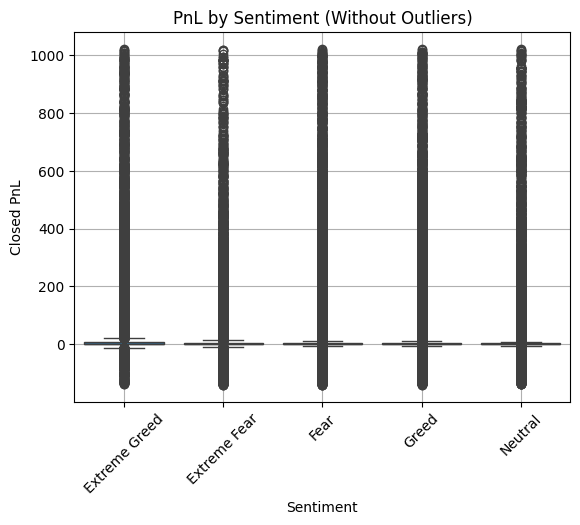

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove extreme outliers (e.g. top/bottom 1%)
filtered_df = merged_df[(merged_df['Closed PnL'] > merged_df['Closed PnL'].quantile(0.01)) &
                        (merged_df['Closed PnL'] < merged_df['Closed PnL'].quantile(0.99))]

sns.boxplot(data=filtered_df, x='Sentiment', y='Closed PnL')
plt.title("PnL by Sentiment (Without Outliers)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [4]:
print(merged_df.groupby('Sentiment')['Closed PnL'].mean())

Sentiment
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64


In [5]:
summary = merged_df.groupby(['date', 'Sentiment']).agg({
    'Closed PnL': ['mean', 'sum'],
    'Size USD': 'sum',
    'Account': 'nunique'
}).reset_index()
summary.columns = ['date', 'Sentiment', 'Avg_PnL', 'Total_PnL', 'Total_Trade_Volume', 'Unique_Traders']
summary.head()

,date,Sentiment,Avg_PnL,Total_PnL,Total_Trade_Volume,Unique_Traders
0,2023-05-01,Greed,0.000000,0.000000,477.00,1
1,2023-12-05,Extreme Greed,0.000000,0.000000,50005.83,1
2,2023-12-14,Greed,-18.675885,-205.434737,113203.35,1
3,2023-12-15,Greed,-12.316017,-24.632034,10609.95,1
4,2023-12-16,Greed,0.000000,0.000000,15348.77,1


In [6]:
# Compare Buy vs Sell under each sentiment
buy_sell_pnl = merged_df.groupby(['Sentiment', 'Side'])['Closed PnL'].mean().unstack()
print(buy_sell_pnl)

Side                 BUY        SELL
Sentiment                           
Extreme Fear   34.114627   34.980106
Extreme Greed  10.498927  114.584643
Fear           63.927104   45.049641
Greed          25.002302   59.691091
Neutral        29.227429   39.456408


In [7]:
# Trader performance by sentiment
trader_sentiment = merged_df.groupby(['Account', 'Sentiment']).agg({
    'Closed PnL': ['mean', 'sum', 'count'],
    'win': 'mean'
})

trader_sentiment.columns = ['Avg_PnL', 'Total_PnL', 'Trades', 'Win_Rate']
trader_sentiment = trader_sentiment.reset_index()

trader_sentiment.head()


,Account,Sentiment,Avg_PnL,Total_PnL,Trades,Win_Rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Fear,1247.692214,1.247692e+05,100,0.370000
1,0x083384f897ee0f19899168e3b1bec365f52a9012,Extreme Greed,-42.626810,-4.028234e+04,945,0.066667
2,0x083384f897ee0f19899168e3b1bec365f52a9012,Fear,626.194346,1.113374e+06,1778,0.526434
3,0x083384f897ee0f19899168e3b1bec365f52a9012,Greed,482.089321,2.767193e+05,574,0.160279
4,0x083384f897ee0f19899168e3b1bec365f52a9012,Neutral,298.456334,1.256501e+05,421,0.581948


In [8]:
merged_df.groupby('Sentiment')[['Closed PnL','risk_adjusted','Size USD']].mean()


,Closed PnL,risk_adjusted,Size USD
Sentiment,,,
Extreme Fear,34.537862,0.004321,5349.731843
Extreme Greed,67.892861,0.040027,3112.251565
Fear,54.290400,0.015412,7816.109931
Greed,42.743559,0.019653,5736.884375
Neutral,34.307718,0.009936,4782.732661


In [9]:
trader_perf = merged_df.groupby('Account').agg({
    'Closed PnL': ['sum','mean'],
    'win': 'mean',
    'Size USD': 'sum',
    'Trade ID': 'count'
})

trader_perf.columns = ['Total_PnL','Avg_PnL','Win_Rate','Capital_Deployed','Trades']
trader_perf = trader_perf.sort_values('Total_PnL', ascending=False)

trader_perf.head(10)


,Total_PnL,Avg_PnL,Win_Rate,Capital_Deployed,Trades
Account,,,,,
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,2.143383e+06,145.481748,0.337134,5.654357e+07,14733
0x083384f897ee0f19899168e3b1bec365f52a9012,1.600230e+06,419.127768,0.359612,6.169726e+07,3818
0xbaaaf6571ab7d571043ff1e313a9609a10637864,9.401638e+05,44.364091,0.467582,6.803634e+07,21192
0x513b8629fe877bb581bf244e326a047b249c4ff1,8.404226e+05,68.684419,0.401193,4.208766e+08,12236
0xbee1707d6b44d4d52bfe19e41f8a828645437aab,8.360806e+05,20.806305,0.428230,7.410781e+07,40184
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,6.777471e+05,155.589314,0.486226,3.957295e+07,4356
0x72743ae2822edd658c0c50608fd7c5c501b2afbd,4.293556e+05,270.034947,0.345912,1.147450e+07,1590
0x430f09841d65beb3f27765503d0f850b8bce7713,4.165419e+05,336.735548,0.484236,2.966109e+06,1237
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,3.790954e+05,38.319560,0.810876,2.572950e+07,9893


In [10]:
regime = merged_df.groupby(['Account','Sentiment'])['Closed PnL'].sum().unstack()

regime['Fear_PnL'] = regime.get('Fear',0)
regime['Greed_PnL'] = regime.get('Greed',0)

elite = regime[(regime['Fear_PnL']>0) & (regime['Greed_PnL']>0)]
elite.sort_values(['Fear_PnL','Greed_PnL'],ascending=False).head(10)


Sentiment,Extreme Fear,Extreme Greed,Fear,Greed,Neutral,Fear_PnL,Greed_PnL
Account,,,,,,,
0x083384f897ee0f19899168e3b1bec365f52a9012,124769.221441,-4.028234e+04,1.113374e+06,276719.270187,125650.116740,1.113374e+06,276719.270187
0xbaaaf6571ab7d571043ff1e313a9609a10637864,261917.977792,NaN,6.208724e+05,4.672458,57368.780126,6.208724e+05,4.672458
0x513b8629fe877bb581bf244e326a047b249c4ff1,-71121.820704,0.000000e+00,3.671662e+05,163047.664946,381330.494050,3.671662e+05,163047.664946
0x4acb90e786d897ecffb614dc822eb231b4ffb9f4,166696.399486,2.049605e+04,2.967817e+05,96392.783186,97380.090931,2.967817e+05,96392.783186
0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3,37712.523409,6.053161e+03,2.367977e+05,30258.203855,-90302.553718,2.367977e+05,30258.203855
0x72c6a4624e1dffa724e6d00d64ceae698af892a0,198900.561610,5.735853e+02,1.445143e+05,21077.717000,-4526.698469,1.445143e+05,21077.717000
0x420ab45e0bd8863569a5efbb9c05d91f40624641,9461.082288,4.019619e+03,9.964828e+04,12082.950000,74293.663505,9.964828e+04,12082.950000
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,9544.906134,1.105305e+06,9.316516e+04,534058.236330,401309.434693,9.316516e+04,534058.236330
0xbee1707d6b44d4d52bfe19e41f8a828645437aab,30774.092128,4.788115e+05,5.597880e+04,243399.513140,27116.682664,5.597880e+04,243399.513140


**Key Finding: Trader Robustness Across Market Emotions**

While most traders perform well in either Fear or Greed, only a small subset remains profitable across both regimes. These traders show lower emotional sensitivity and better risk management, making them ideal candidates for capital allocation or copy trading strategies.